# **DATASET**

В датасете представлены англоязычные сообщений в Twitter, разделенные по шести основным эмоциям: гнев, страх, радость, любовь, печаль и удивление. Каждая запись в этом наборе данных состоит из текстового сегмента, представляющего сообщение в Twitter, и соответствующей метки, указывающей на преобладающую передаваемую эмоцию. Эмоции делятся на шесть категорий: грусть (0), радость (1), любовь (2), гнев (3), страх (4) и удивление (5).

# **Загрузка библиотек**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Загрузка датасета**

In [3]:
df = pd.read_csv('text.csv')

In [4]:
df.head(10)

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4.0
1,1,ive enjoyed being able to slouch about relax a...,0.0
2,2,i gave up my internship with the dmrg and am f...,4.0
3,3,i dont know i feel so lost,0.0
4,4,i am a kindergarten teacher and i am thoroughl...,4.0
5,5,i was beginning to feel quite disheartened,0.0
6,6,i would think that whomever would be lucky eno...,2.0
7,7,i fear that they won t ever feel that deliciou...,1.0
8,8,im forever taking some time out to have a lie ...,5.0
9,9,i can still lose the weight without feeling de...,0.0


# **Чистка данных**

**Повышение точности:** Чистые данные приводят к более точным результатам анализа и моделирования. Удаление неактуальной или неверной информации гарантирует, что анализ основан на достоверных данных.

**Повышение читаемости:** Очищенный текст легче читать и понимать.

**Удаление шумов:** Текстовые данные часто содержат шум в виде специальных символов, знаков препинания и других ненужных элементов. Очистка помогает удалить этот шум, сосредоточившись на релевантном контенте.

**Стандартизация:** Очистка включает в себя стандартизацию текста путем его преобразования в единый формат. Это помогает точно сопоставлять и сравнивать текстовые данные.

**Предотвращение предвзятости:** Очистка текста может помочь уменьшить предвзятость при анализе данных. Например, удаление гендерных местоимений помогает предотвратить гендерную предвзятость при анализе настроений.

**Повышение эффективности:** Очищенные данные позволяют повысить эффективность обработки и анализа. Алгоритмы могут более эффективно работать с чистыми, структурированными данными.


In [6]:
df.columns

Index(['Unnamed: 0', 'text', 'label'], dtype='object')

In [7]:
# We have droped the extra column
df.drop(columns='Unnamed: 0', inplace=True)

In [8]:
# checking the shape
print(f'The Shape Of Data Is : {df.shape}')

The Shape Of Data Is : (39154, 2)


In [9]:
# checking the duplicates we have found some so we are going to remove them
df.duplicated().sum()

9

In [10]:
# removing the duplicates
df = df.drop_duplicates()

In [11]:
# rechecking the duplicates
df.duplicated().sum()

0

In [12]:
# we need to map the data so we can get the good visualization
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
    # Add more mappings as needed
}

df['label'] = df['label'].map(emotion_map)

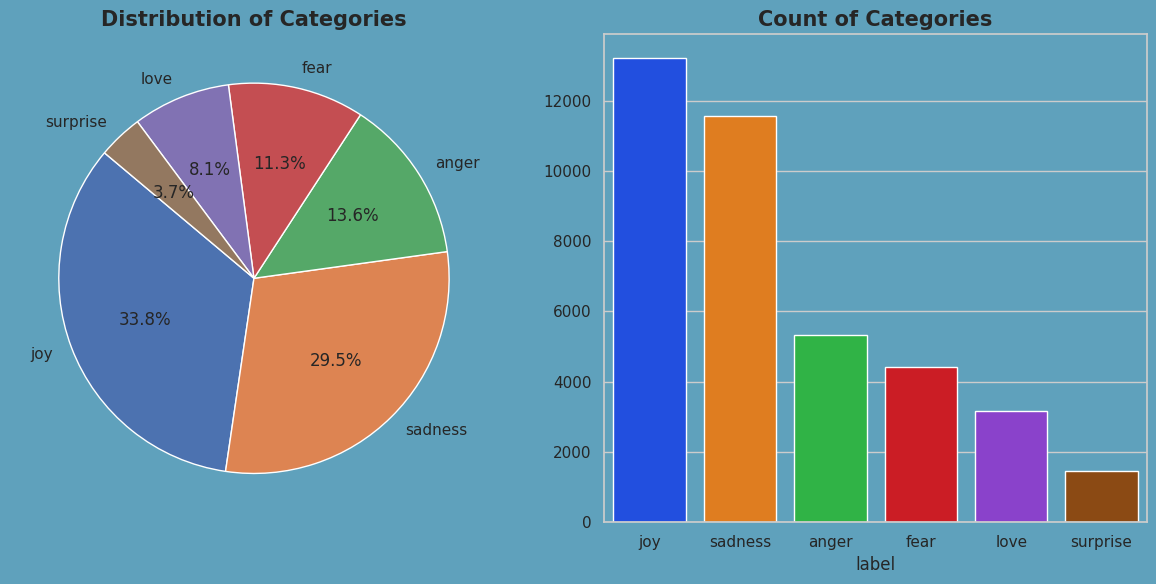

In [13]:
# Value count of 'label'
count = df['label'].value_counts()

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)

# Plot pie chart on the first subplot
palette = sns.color_palette("bright", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Count of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# CHAT WORDS

Это неформальные выражения, используемые в онлайн-общении, такие как «lol» и «brb».
Их необходимо обрабатывать в процессе обработки текста, чтобы нормализовать и понять их.

In [14]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [15]:
# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Apply replace_chat_words function to 'Text' column
df['text'] = df['text'].apply(replace_chat_words)

# Лишних символы

In [16]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

df.head()

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


# Стоп слова

In [17]:
stop = stopwords.words('english')
df["text"] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


# Преобразование всех букв в строчные

In [18]:
df['text'] = df['text'].str.lower()
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


# Числа

In [19]:
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


# Лишние пробелы и переносы строк

In [20]:
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


# Специальные символы

In [21]:
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


# URLs

In [22]:
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


# **DATA VISUALIZATION**

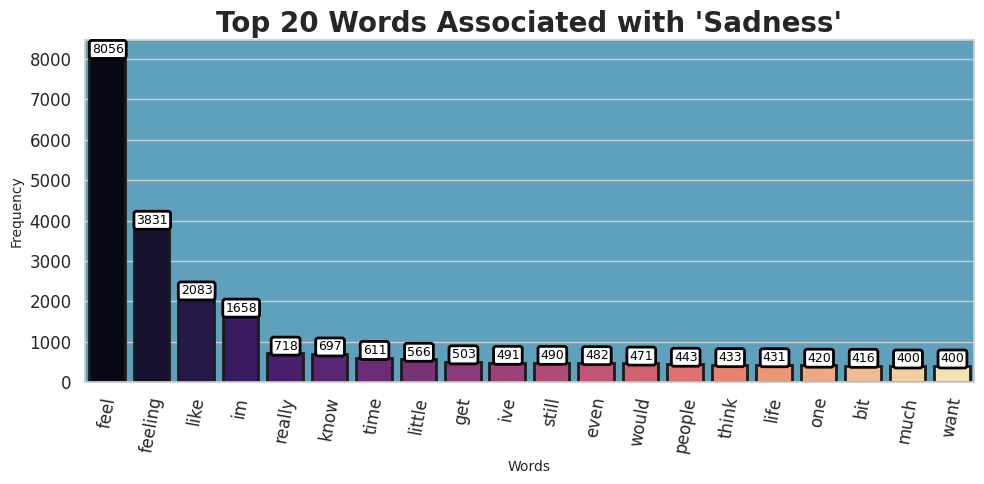

In [23]:
love_texts = df[df['label'] == 'sadness']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Sadness'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

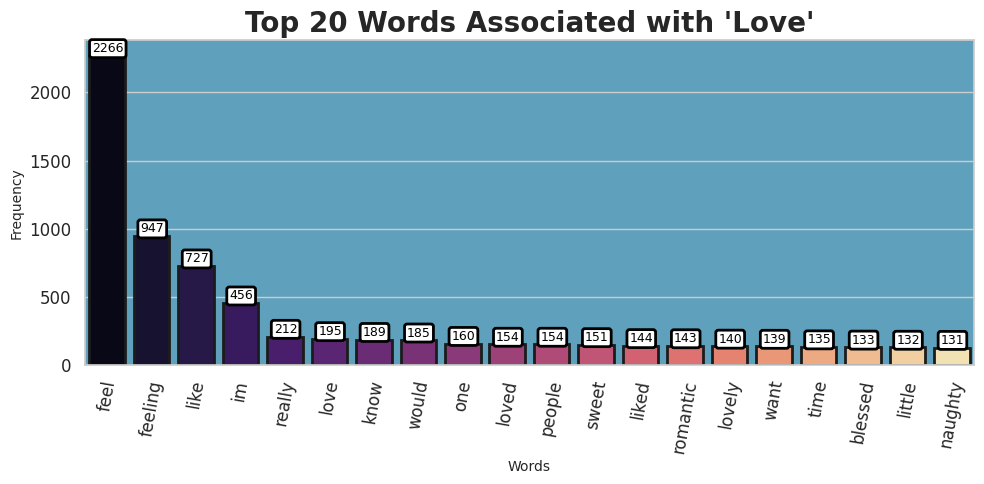

In [24]:
love_texts = df[df['label'] == 'love']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Love'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


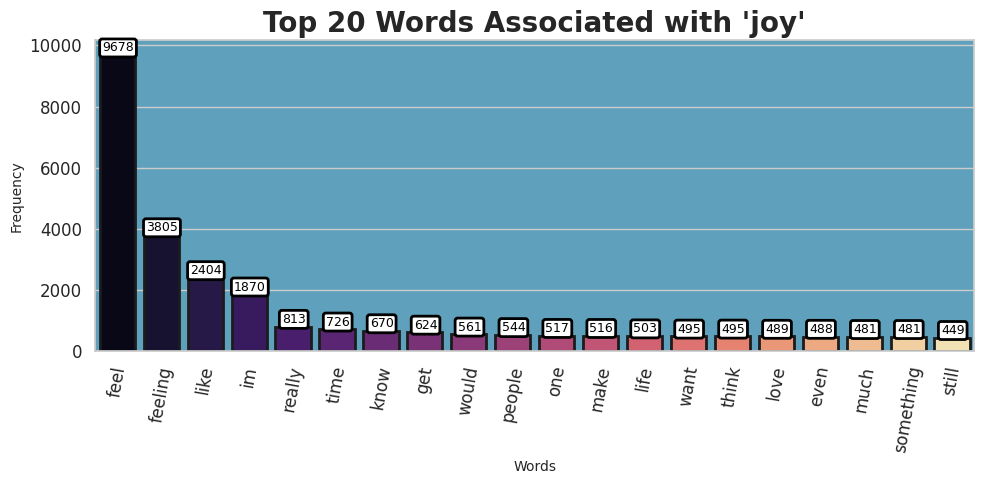

In [25]:
love_texts = df[df['label'] == 'joy']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'joy'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

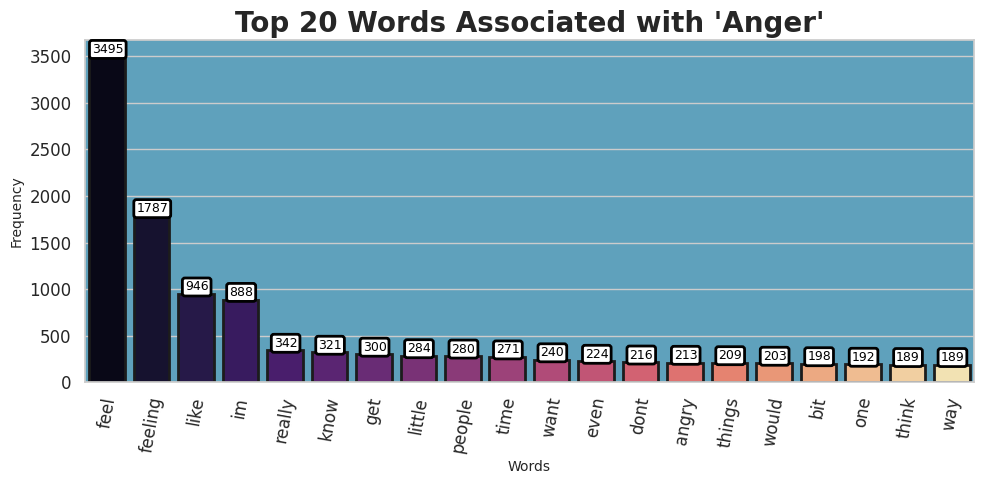

In [26]:
love_texts = df[df['label'] == 'anger']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Anger'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

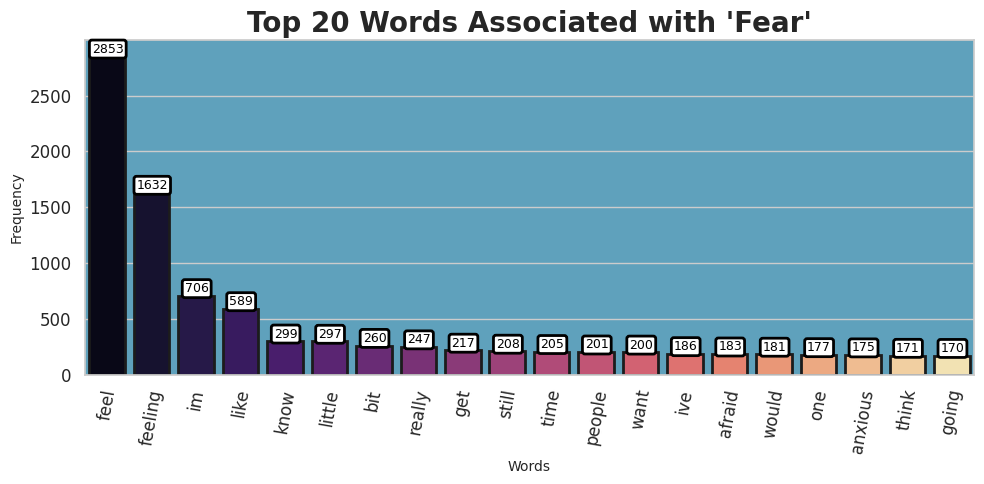

In [27]:
love_texts = df[df['label'] == 'fear']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Fear'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

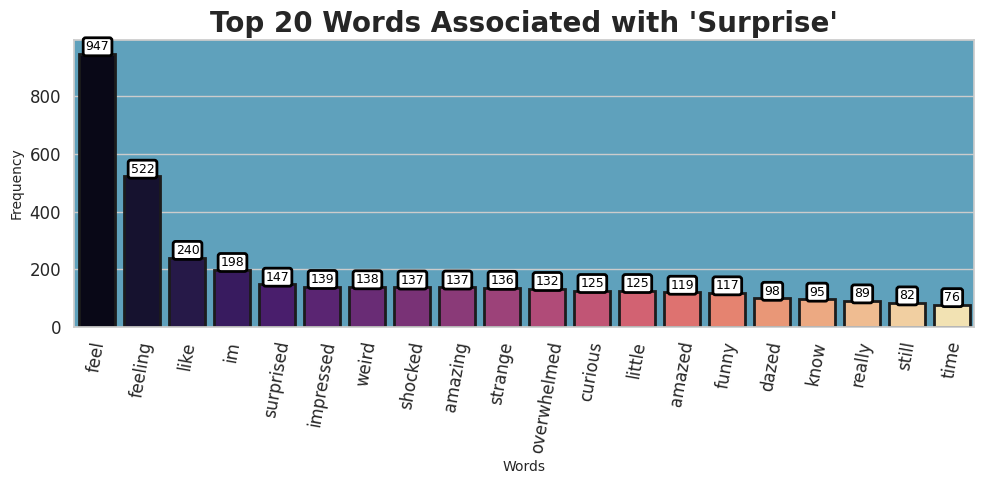

In [28]:
love_texts = df[df['label'] == 'surprise']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and themesss
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Surprise'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Взгляд на очищенные данные

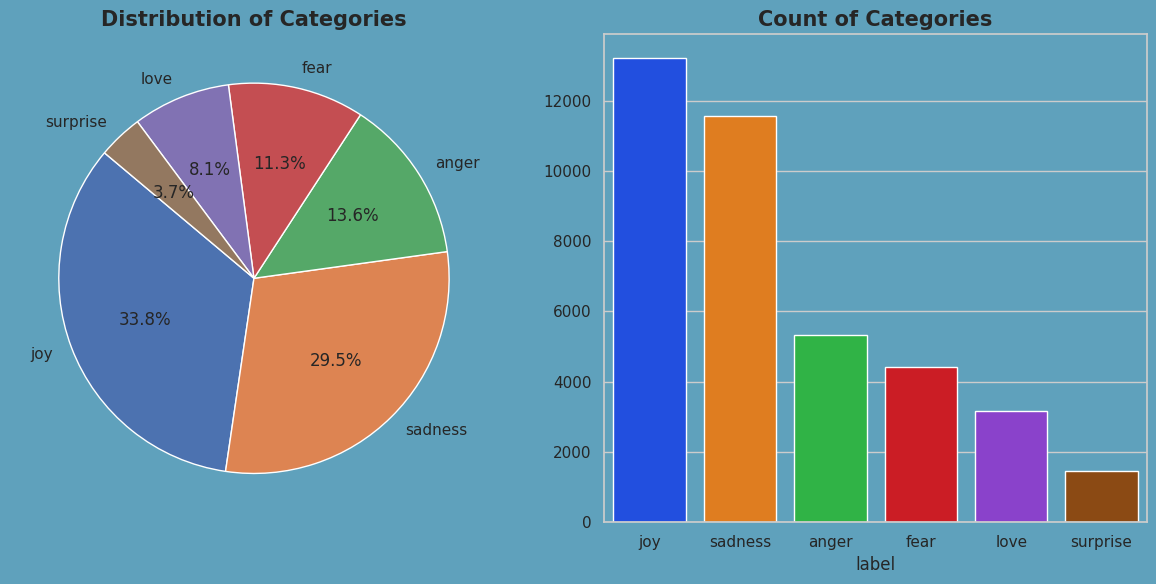

In [29]:
# Value count of 'label'
count = df['label'].value_counts()

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)

# Plot pie chart on the first subplot
palette = sns.color_palette("bright", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Count of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [30]:
df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


In [31]:
# Define a mapping dictionary
label_mapping = {'sadness':0, 'joy':1, 'love':2, 'anger':3, 'fear':4,'surprise':5}

# Rename the 'Label' column using the mapping dictionary
df['label'] = df['label'].map(label_mapping)

In [32]:
#  now you can see that the fear sadness etc convert into numbers which will make our
# task easy in terms of computation and speed
df.head()

,text,label
0,feel really helpless heavy hearted,4.0
1,ive enjoyed able slouch relax unwind frankly n...,0.0
2,gave internship dmrg feeling distraught,4.0
3,dont know feel lost,0.0
4,kindergarten teacher thoroughly weary job take...,4.0


# Training the Data

In [33]:
# splitting the data
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("The shape of X_train is ", X_train.shape)
print("The shape of X_test is ", X_test.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_test is", y_test.shape)

The shape of X_train is  (31316,)
The shape of X_test is  (7829,)
The shape of y_train is (31316,)
The shape of y_test is (7829,)


# Tokenization

In [34]:
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [35]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [36]:
# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 44


In [37]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

In [38]:
# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[ 561    2  959 ...    0    0    0]
 [ 776 1154   50 ...    0    0    0]
 [   2  299  128 ...    0    0    0]
 ...
 [  39   18   67 ...    0    0    0]
 [8657 2514    9 ...    0    0    0]
 [ 624    1  236 ...    0    0    0]]

X_test_padded:
[[ 1711  2825  7855 ...     0     0     0]
 [21816   403 21817 ...     0     0     0]
 [    1   891   579 ...     0     0     0]
 ...
 [   15     1     3 ...     0     0     0]
 [  132     1   408 ...     0     0     0]
 [   17  2538   931 ...     0     0     0]]


In [39]:
# Embedding Input Size
input_size = np.max(X_train_padded) + 1
input_size

21816

# **Model**

In [40]:
# Define the model
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=input_size, output_dim=100,input_shape=(79,)))

# Add a bidirectional GRU layer with 128 units
model.add(Bidirectional(LSTM(128)))

# Add batch normalization layer
model.add(BatchNormalization())

# Add dropout regularization
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 6 units for 6 labels and softmax activation
model.add(Dense(6, activation='softmax'))

In [41]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 79, 100)           2181600   
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [49]:
# Model Train
history = model.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_data=(X_test_padded, y_test),callbacks=[EarlyStopping(patience=3)])

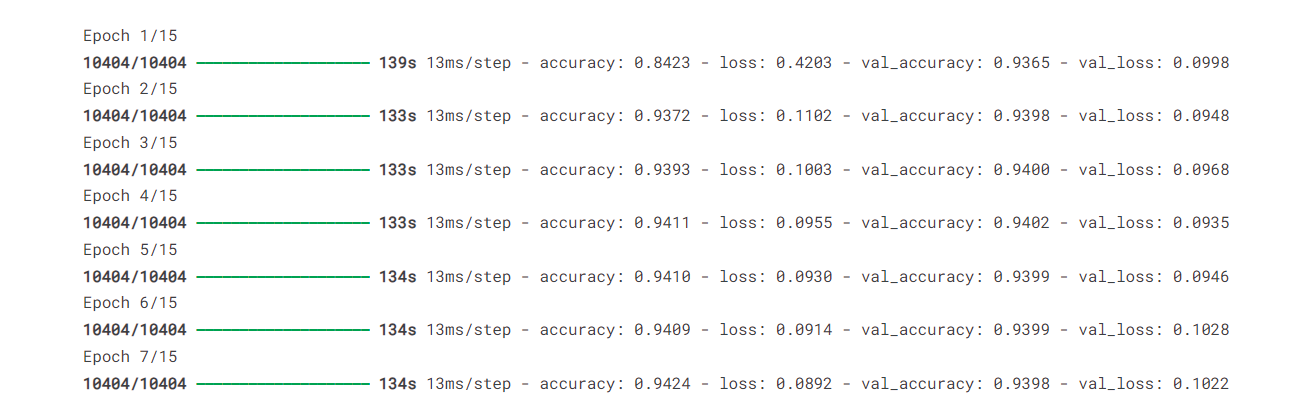

In [ ]:
# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

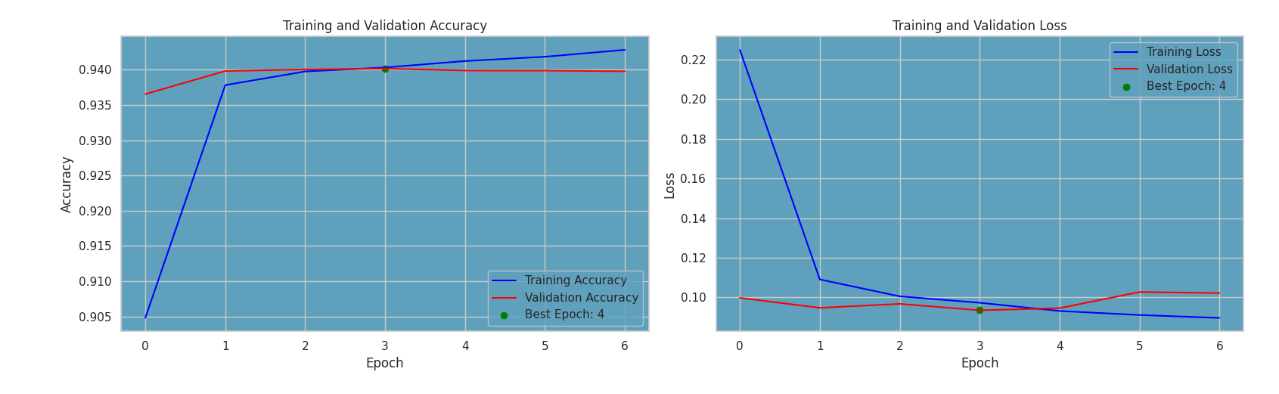

In [ ]:
# Evaluate Test Data
model.evaluate(X_test_padded, y_test)

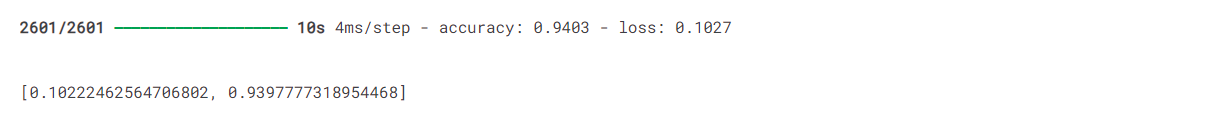

In [ ]:
# Predictions On Test For Confustion Matrix
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

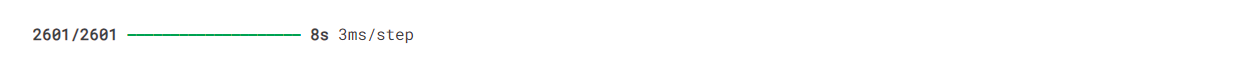

In [ ]:
# y_test and y_pred are your true and predicted labels
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with blue color
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Change 'Reds' to 'Blues' for blue color
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

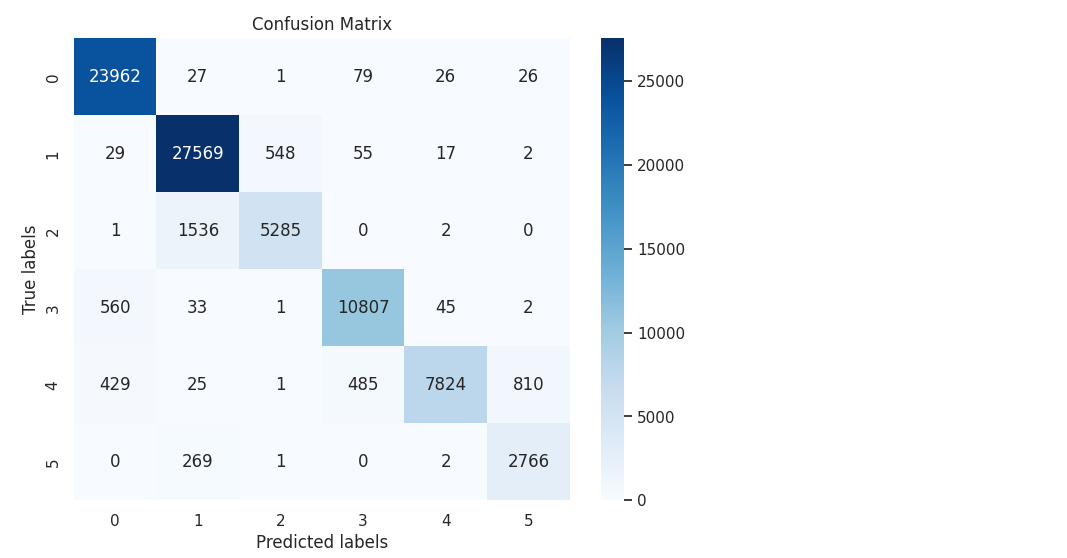